**Names of all group members:**
Zhexin Wu,

---

All code below is only suggestive and you may as well use different approaches.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from typing import Dict, List

In [2]:
sns.set_theme()

In [3]:
# Configs
CONFIG = {
    "q1": {
        "m": 20_000,
        "n": 10_000,
        "age_range": (18, 80),
        "income_range": (1, 15),
        "prob_self_employed": 0.1,
    },
}

In [4]:
# Exercise 1.
import numpy as np
np.random.seed(0)  # for reproducibility

# simulate explanatory variables x
def create_train_test_samples(q1_config: dict):
    m, n = q1_config["m"], q1_config["n"]
    num_samples = m + n
    all_feats = np.stack(
        [
            np.random.uniform(*q1_config["age_range"], size=(num_samples,)),
            np.random.uniform(*q1_config["income_range"], size=(num_samples,)),
            (np.random.uniform(0, 1, size=(num_samples,)) <= q1_config["prob_self_employed"]).astype(int)
        ],
        axis=1,
    )
    all_feats = pd.DataFrame(all_feats, columns=["age", "income", "self_employed"])
    X_train = all_feats.iloc[:m, :]
    X_test = all_feats.iloc[-n:, :]
    
    return X_train, X_test

X_train, X_test = create_train_test_samples(CONFIG["q1"])
X_all = pd.concat([X_train, X_test], axis=0)

# a) calculate empirical means and standard deviations over training data
print(f"Shape of training and test sets: {X_train.shape}, {X_test.shape}")
print(f"Shape of all feats: {X_all.shape}")

Shape of training and test sets: (20000, 3), (10000, 3)
Shape of all feats: (30000, 3)


In [5]:
X_train.agg(["mean", "std"])

,age,income,self_employed
mean,48.742654,7.986522,0.098350
std,18.007888,4.030904,0.297795


In [6]:
# b) Can you come up with a few (2 or 3) additional features that may be relevant?
# (you don't have to implement those of course, just write down your answer in text)

We can consider other features like
- Debt-to-income ratio: The ratio of current outstanding debt to monthly income. The likelihood of not default increases as the ratio decreases.
- Martial status: Married individuals might have a more stable financial profile.
- Number of dependents: Number of dependents can affect the risk of default.

In [7]:
# Exercise 2.
# Building the datasets:

sigmoid = lambda x: 1. / (1. + np.exp(-x))

def prob_func(feats_in: pd.DataFrame, func_number: int):
    """
    p1 and p2.
    
    Parameters
    ----------
    feats_in: pd.DataFrame
        Of shape (num_samples, num_feats)
    """
    assert func_number in [1, 2]
    
    feats = feats_in.values
    if func_number == 1:
        logits = 13.3 + feats @ np.array([-0.33, 3.5, -3])  # (num_samples,)
        
        return sigmoid(logits)
    
    else:
        logits = 5 - 10 * ((feats[:, 0] <= 25) | (feats[:, 0] >= 75)) + 1.1 * feats[:, 1] - feats[:, 2]
        
        return sigmoid(logits)

In [8]:
ξ = np.random.rand(X_all.shape[0])
# build the first dataset
y_all_1 = (ξ <= prob_func(X_all, 1))
y_train_1 = pd.Series((y_all_1[:CONFIG["q1"]["m"]]).astype(int))
y_test_1 = pd.Series((y_all_1[-CONFIG["q1"]["n"]:]).astype(int))
print(f"Shape of training and test labels, dataset 1: {y_train_1.shape}, {y_test_1.shape}")

# build the second dataset
y_all_2 = (ξ <= prob_func(X_all, 2))
y_train_2 = pd.Series((y_all_2[:CONFIG["q1"]["m"]]).astype(int))
y_test_2 = pd.Series((y_all_2[-CONFIG["q1"]["n"]:]).astype(int))
print(f"Shape of training and test labels, dataset 2: {y_train_2.shape}, {y_test_2.shape}")

Shape of training and test labels, dataset 1: (20000,), (10000,)
Shape of training and test labels, dataset 2: (20000,), (10000,)


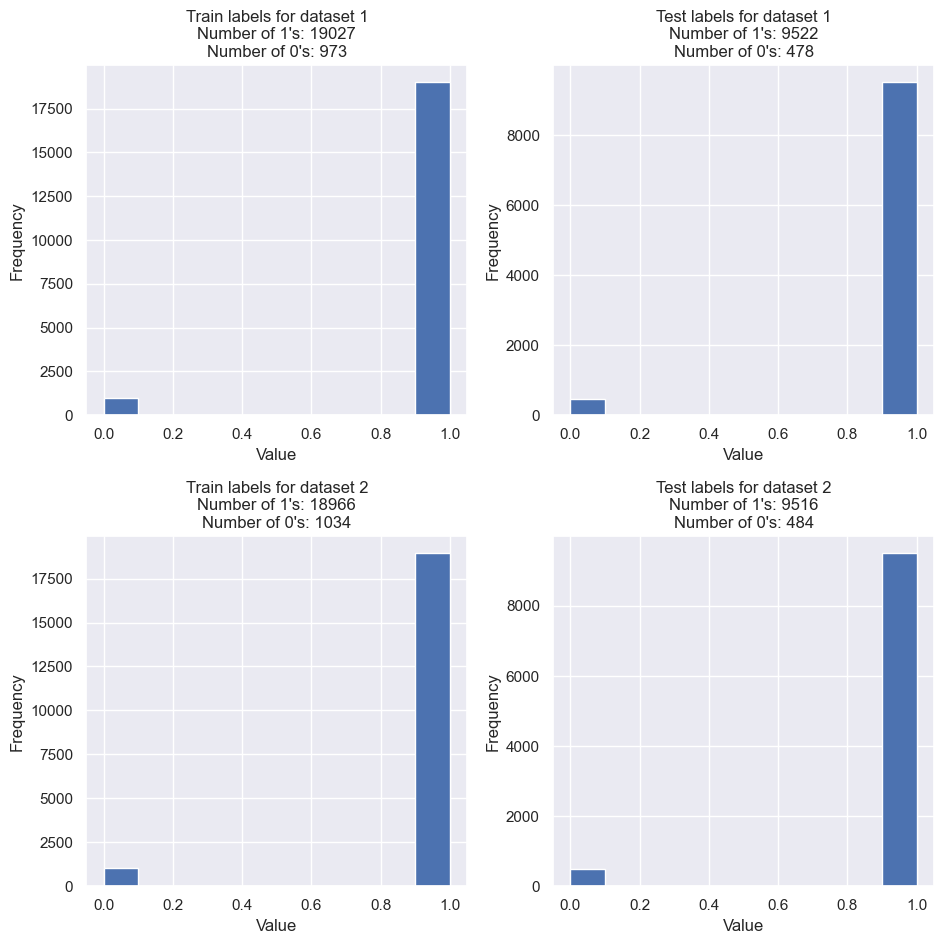

In [9]:
# Inspect the distribution of labels of the two datasets
fig, axes = plt.subplots(2, 2, figsize=(9.6, 9.6))
y_collection = [
    [y_train_1, y_test_1],
    [y_train_2, y_test_2],
]
titles = ["Train", "Test"]
for i in range(2):
    for j in range(2):
        axis = axes[i, j]
        y_iter = y_collection[i][j]
        y_iter.plot(kind="hist", ax=axis)
        axis.set_xlabel("Value")
        axis.set_title(f"{titles[j]} labels for dataset {i + 1}\nNumber of 1's: {(y_iter == 1).sum()}\nNumber of 0's: {(y_iter == 0).sum()}")

fig.tight_layout()

<span style="color: blue;"><b>Notes:</b></span>
- Dataset 1 & 2 are highly imbalanced

In [10]:
# Exercise 2. a)
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator
from sklearn.metrics import log_loss, precision_recall_curve, auc
from sklearn.svm import SVC
# "model = LogisticRegression().fit(X_data, Y_data)" fits a model
# "pred_X = model.predict_proba(X)" evaluates the model
# (note that it outputs both P(Y=0|X) and P(Y=1|X))
# "log_loss(Y, pred_X)" evaluates the negative conditional log likelihood (also called cross-entropy loss)

In [11]:
def __shared_train_and_test(model: BaseEstimator, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_train_pred = model.predict_proba(X_train)[:, 1]
    y_test_pred = model.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_test_pred)
    fdr_test = 1 - precision
    auc_val = auc(recall, fdr_test)
    metrics = {
        "log_loss_train": log_loss(y_train, y_train_pred),
        "log_loss_test": log_loss(y_test, y_test_pred),
        "fdr_test": fdr_test,
        "tpr_test": recall,
        "auc_test": auc_val,
    }
    
    return model, metrics


def logistic_reg(X_train, y_train, X_test, y_test, **model_params):
    model = LogisticRegression(**model_params)
    model, metrics = __shared_train_and_test(model, X_train, y_train, X_test, y_test)
    
    return model, metrics


def svm_clf(X_train, y_train, X_test, y_test, **model_params):
    X_train_std = X_train.std()
    X_train = X_train / X_train_std
    X_test = X_test / X_train_std
    model = SVC(**model_params)
    model, metrics = __shared_train_and_test(model, X_train, y_train, X_test, y_test)
    
    return model, metrics
    

def model_eval(metrics: List[Dict[str, dict]], **kwargs):
    """
    Plot FDR-TPR curve for both datasets. Overlap curves for both models and datasets.
    
    Parameters
    ----------
    metrics: List[Dict[str, dict]]
        [{
            "log_reg": dict,
            "svm": dict,
        }...]
    """
    figsize = kwargs.get("figsize", (9.6, 4.8))
    fig, axis = plt.subplots(figsize=figsize)
    
    for ds_idx in range(len(metrics)):
        ds_num = ds_idx + 1
        metrics_iter = metrics[ds_idx]
        for metric_name, metric_dict in metrics_iter.items():
            label = f"Dataset {ds_num}, model {metric_name}, AUC = {metric_dict['auc_test']:.6f}"
            axis.plot(metric_dict["tpr_test"], metric_dict["fdr_test"], label=label)
    
    axis.set_xlabel("TPR")
    axis.set_ylabel("FDR")
    axis.legend()
    
    return fig, axis

In [12]:
# Fit the models on both datasets
log_reg1, log_reg_metrics1 = logistic_reg(X_train, y_train_1, X_test, y_test_1)
log_reg2, log_reg_metrics2 = logistic_reg(X_train, y_train_2, X_test, y_test_2)

# Calculate cross-entropy loss on both datasets for train and test
for idx, metric_iter in enumerate([log_reg_metrics1, log_reg_metrics2]):
    print(f"Cross-entropy loss of logistic regression on dataset{idx + 1}:")
    print(f"Train: {metric_iter['log_loss_train']:.5f}, Test: {metric_iter['log_loss_test']:.5f}")

Cross-entropy loss of logistic regression on dataset1:
Train: 0.02920, Test: 0.03573
Cross-entropy loss of logistic regression on dataset2:
Train: 0.15291, Test: 0.14708


In [13]:
# Exercise 2. b)
# Calculate normalized data

See `svm_clf(.)` above.

In [14]:
# Exercise 2.b) (i) and (ii)
from sklearn.svm import SVC
# "model = SVC(kernel='rbf', gamma=GAMMA, C=C, probability=True)" creates
# a model with kernel exp(-GAMMA \|x-x'\|_2^2) and regul. parameter C (note the relation between C and the parameter lambda from the lecture).
# "probability=True" enables the option "model.predict_proba(X)" to predict probabilities from the regression function \hat{f}^{svm}.
# "model.fit(X, Y)" optimizes the model parameters (using hinge loss)

# Fit the models for both datasets (this can take up to 60 seconds with SVC)
svm_params = dict(
    C=0.2,
    kernel="rbf",
    gamma=0.1,
    probability=True,
)

In [15]:
%%time
"""
This cell can take longer (<= 30s) to run.
"""
# Exercise 2.b (iii)
# "model.predict_proba(X)" predicts probabilities from features (note that it outputs both P(Y=0|X) and P(Y=1|X))
svm1, svm_metrics1 = svm_clf(X_train, y_train_1, X_test, y_test_1, **svm_params)
svm2, svm_metrics2 = svm_clf(X_train, y_train_2, X_test, y_test_2, **svm_params)

# Calculate cross-entropy loss on both datasets for train and test
for idx, metric_iter in enumerate([svm_metrics1, svm_metrics2]):
    print(f"Cross-entropy loss of logistic regression on dataset{idx + 1}:")
    print(f"Train: {metric_iter['log_loss_train']:.5f}, Test: {metric_iter['log_loss_test']:.5f}")

Cross-entropy loss of logistic regression on dataset1:
Train: 0.03138, Test: 0.04105
Cross-entropy loss of logistic regression on dataset2:
Train: 0.07080, Test: 0.06685
CPU times: total: 19.1 s
Wall time: 19.1 s


In [16]:
# Exercise 2.c
import matplotlib.pyplot as plt
# To calculate the curves, it is fine to take 100 threshold values c, i.e.,
ths = np.linspace(0, 1, 100)

# To approximately calculate the AUC, it is fine to simply use Riemann sums.
# This means, if you have 100 (a_i, b_i) pairs for the curves, a_1 <= a_2 <= ...
# then you may simply use the sum
# sum_{i=1}^99 (b_i + b_{i+1})/2 * (a_{i+1}-a_i)
# as the approximation of the integral (or AUC)


# first data set & logistic regression:
# (the code should be reusable for all cases, only exchanging datasets and predicted probabilities depending on the model)

# Calculate positives (only depending on the dataset)

# Calculate true positives for all threshold values

# Calculate false positives for all threshold values

# Calculate FDR and TPR rate (points on the FDR/TPR curve) and the AUC


# second data set & logistic regression:


# first data set and rkhs regression:


# second data set and rkhs regression:

The above procedures have been integrated in `__shared_train_and_test(.)` and `model_eval(.)` above.

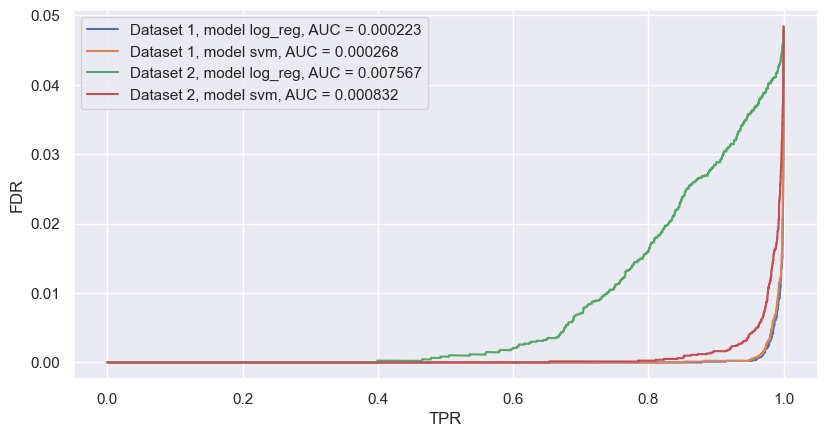

In [17]:
metric_dict_collection = [
    {
        "log_reg": log_reg_metrics1,
        "svm": svm_metrics1,
    },
    {
        "log_reg": log_reg_metrics2,
        "svm": svm_metrics2,
    },
]
fig, axis = model_eval(metric_dict_collection)

<span style="color: blue;"><b>Discussion:</b></span>
- For FDR-TPR curve, the smaller AUC (i.e. flatter curve) the better. Thus SVC is better for both datasets.

In [ ]:
# Exercise 3.

# Set model parameters and define matrix D


# Scenario 1:
# Define Portfolio and possible outcomes for this portfolio using matrix D


# Plot histogram of profits and losses


# Calculate expected profit and losses and 95%-VaR


# Scenario 2:
# Define Portfolio and possible outcomes using the matrix D and the predicted default probabilities from the logistic regression model


# Plot histogram of profits and losses


# Calculate expected profit and losses and 95%-VaR


# Scenario 3:
# Define Portfolio and possible outcomes using the matrix D and the predicted default probabilities from the rkhs model


# Plot histogram of profits and losses


# Calculate expected profit and losses and 95%-VaR